In [2]:
import os
import glob

import tables as tb
import numpy  as np
import pandas as pd

from collections import defaultdict

In [3]:
import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib notebook
%matplotlib inline
### Useful parameters for plots
mpl.rcParams["figure.figsize"]          = 12,10
mpl.rcParams["font.size"]               = 20
mpl.rcParams["figure.max_open_warning"] = 100
mpl.rcParams["font.size"]               = 20
mpl.rcParams["font.weight"]             ='normal'
mpl.rcParams["axes.labelweight"] = "normal"
mpl.rcParams['axes.facecolor'] = 'w'
mpl.rcParams['figure.facecolor'] = 'w';

In [65]:
import invisible_cities.io.pmaps_io as pmapio
import invisible_cities.io.dst_io  as dstio
import invisible_cities.io.mcinfo_io as mcio
import gres.database.load_db as db
import invisible_cities.io.run_and_event_io as rio

import invisible_cities.core.core_functions as coref

from lmfit.models import GaussianModel, LinearModel, ExponentialModel, ConstantModel

In [66]:
nfiles = 100000
datatypes = ['22Na', '83mKr', '133Ba', 'NoSource', '57Co', '241Am', '55Fe']#[2]

In [67]:
fano = 0.15
wi   = 26.4
ws   = 40
dist = 1 #cm

data_pmt = db.DataPMT('gap', 1)
pmt_sigma = (data_pmt.Sigma/data_pmt.adc_to_pes).mean()

def get_el_yield(pressure, voltage, d=1):
    lyield = (81*voltage/pressure/d - 47)*pressure*d
    lyield = np.where(lyield > 0, lyield, 0)
    return lyield 


def get_el_yield_new(pressure, voltage, d=1):
    new_volt = voltage - (1.1-0.58)
    return (81*new_volt/pressure/d - 47)*pressure*d


def get_intrinsic_resolution(energy, fano, wi, det_phot, pmt_sigma):
    fano_term =  fano / (energy/wi)
    det_term  = (1+pmt_sigma**2)/det_phot
    return 235 * np.sqrt(fano_term + det_term)

### Load data

In [68]:
pressure   = 8.62
delta_volt = 5
source     = datatypes[6]
gas        = 'Photoetched'

all_runs = [[rn] for rn in np.arange(762, 779, 1)]
el_volts = np.arange(13.4 ,  6.9, -0.4)[::-1]
labels   = [f'{el_volt:.1f} kV' for el_volt in el_volts] 

datasets_s1 = []
datasets_s2 = []

dst_path = '/home/ander/Work/GaP/real_data/55Fe/Paper1/EL_yield_dst.h5'


for run_numbers in all_runs:    
    data_1_s1 = []
    data_1_s2 = [] 
    
    for run_number in run_numbers:
        inpath = f'/home/ander/Work/GaP/real_data/{source}/R{run_number}/octavia/'
        data_1_s1.append(pd.read_hdf(inpath+f'DST_run_{run_number}_pmaps.h5', 'S1'))
        data_1_s2.append(pd.read_hdf(inpath+f'DST_run_{run_number}_pmaps.h5', 'WVF'))
    
    data_1_s1 = pd.concat(data_1_s1).reset_index(drop=True)    
    data_1_s2 = pd.concat(data_1_s2).reset_index(drop=True)    
    
    data_1_s1['r'] = np.sqrt(data_1_s1.x**2 + data_1_s1.y**2)
    data_1_s2['r'] = np.sqrt(data_1_s2.x**2 + data_1_s2.y**2)
    datasets_s1.append(data_1_s1)
    datasets_s2.append(data_1_s2)

### Look at data

E resolution (7.0 kV) =  112.13%
E resolution (7.4 kV) =  100.38%
E resolution (7.8 kV) =  86.08%
E resolution (8.2 kV) =  71.78%
E resolution (8.6 kV) =  58.84%
E resolution (9.0 kV) =  49.34%
E resolution (9.4 kV) =  39.29%
E resolution (9.8 kV) =  32.99%
E resolution (10.2 kV) =  27.60%
E resolution (10.6 kV) =  22.96%
E resolution (11.0 kV) =  21.02%
E resolution (11.4 kV) =  19.52%
E resolution (11.8 kV) =  18.89%
E resolution (12.2 kV) =  17.69%
E resolution (12.6 kV) =  17.97%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E resolution (13.0 kV) =  18.73%
E resolution (13.4 kV) =  20.78%


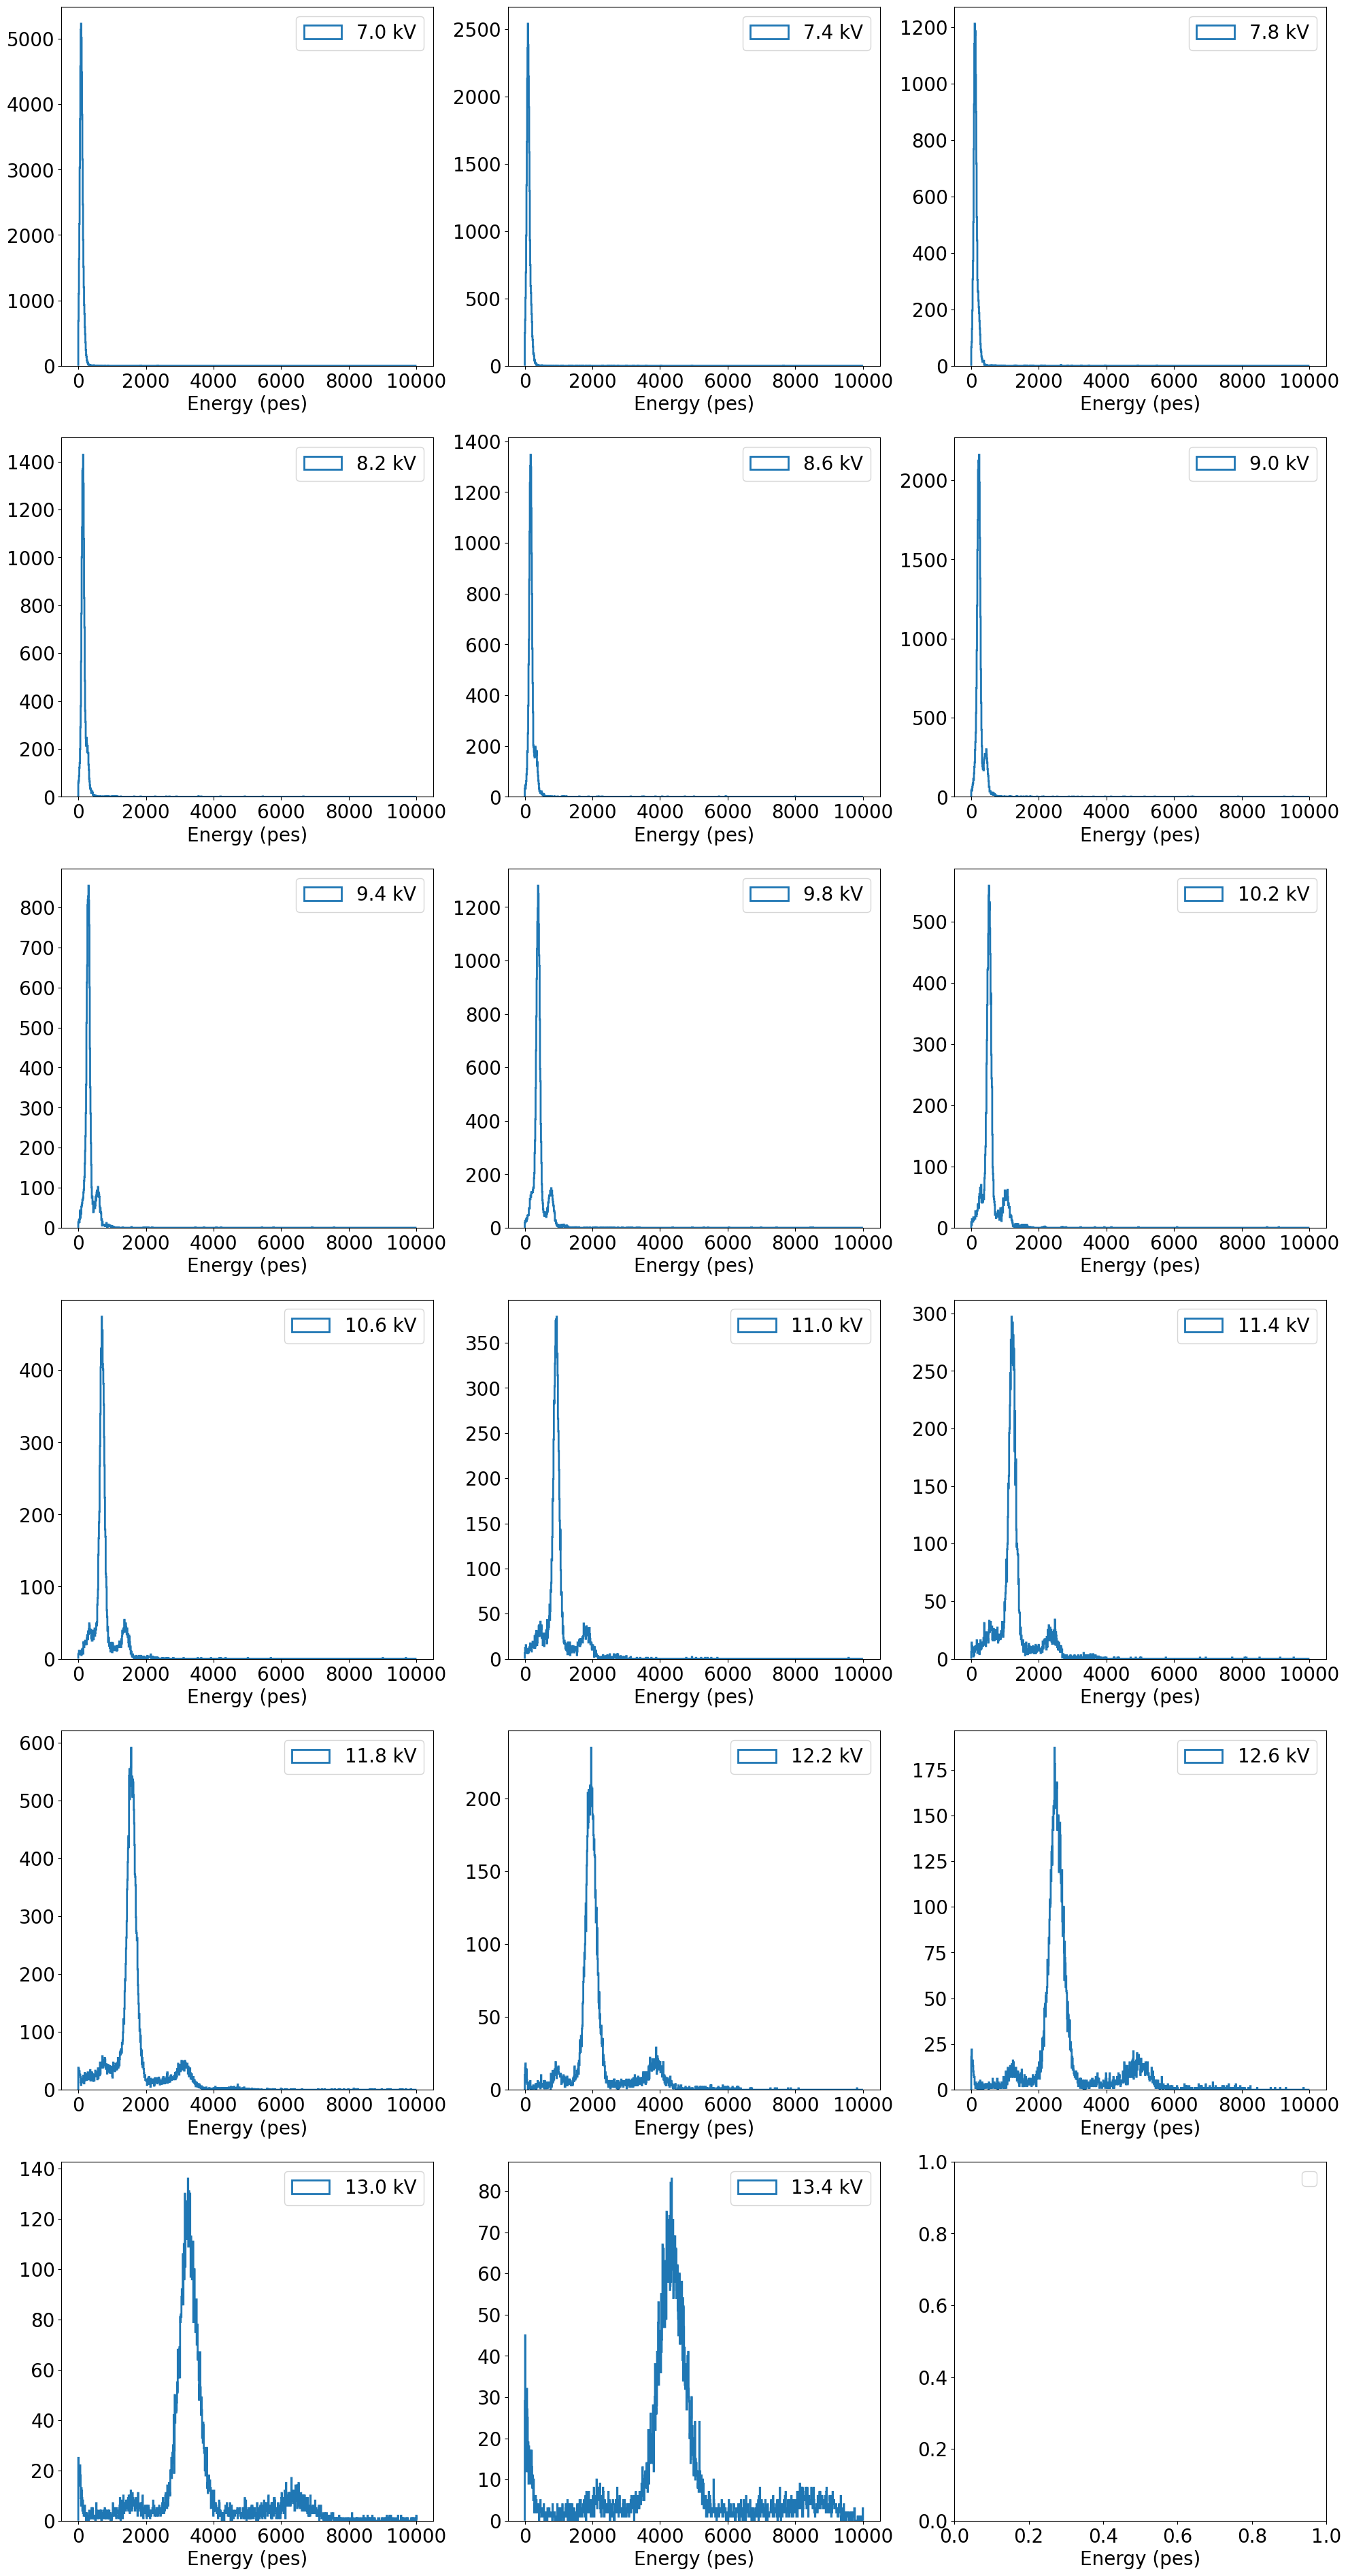

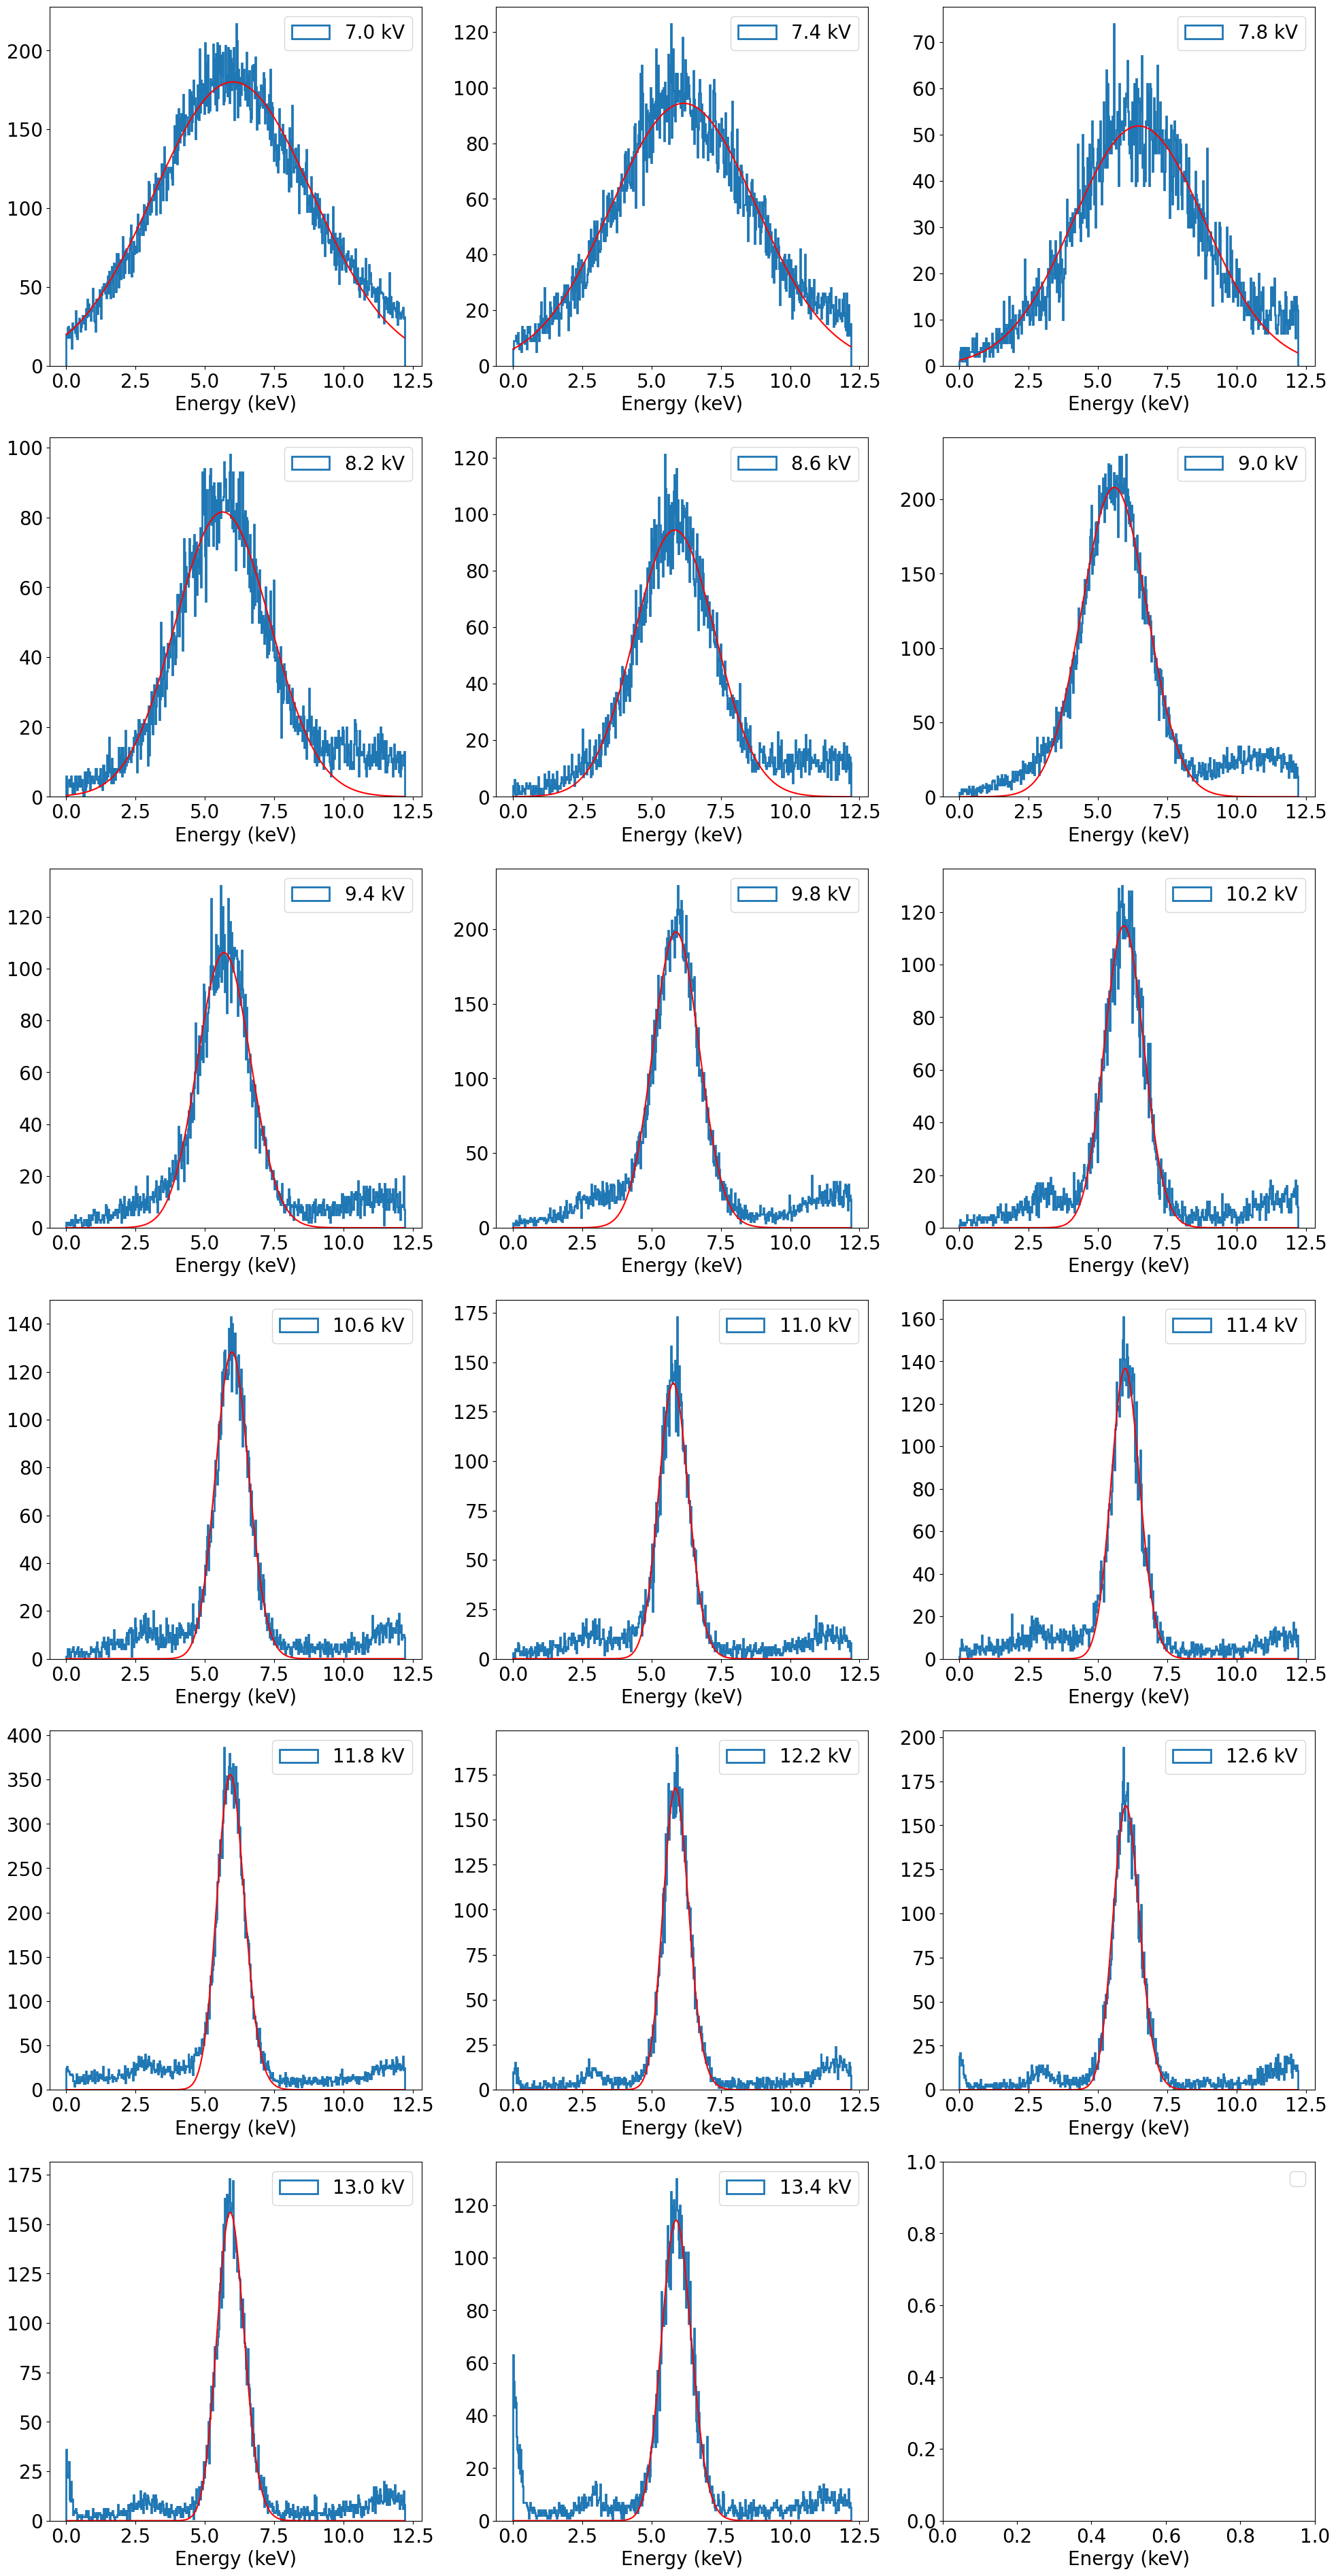

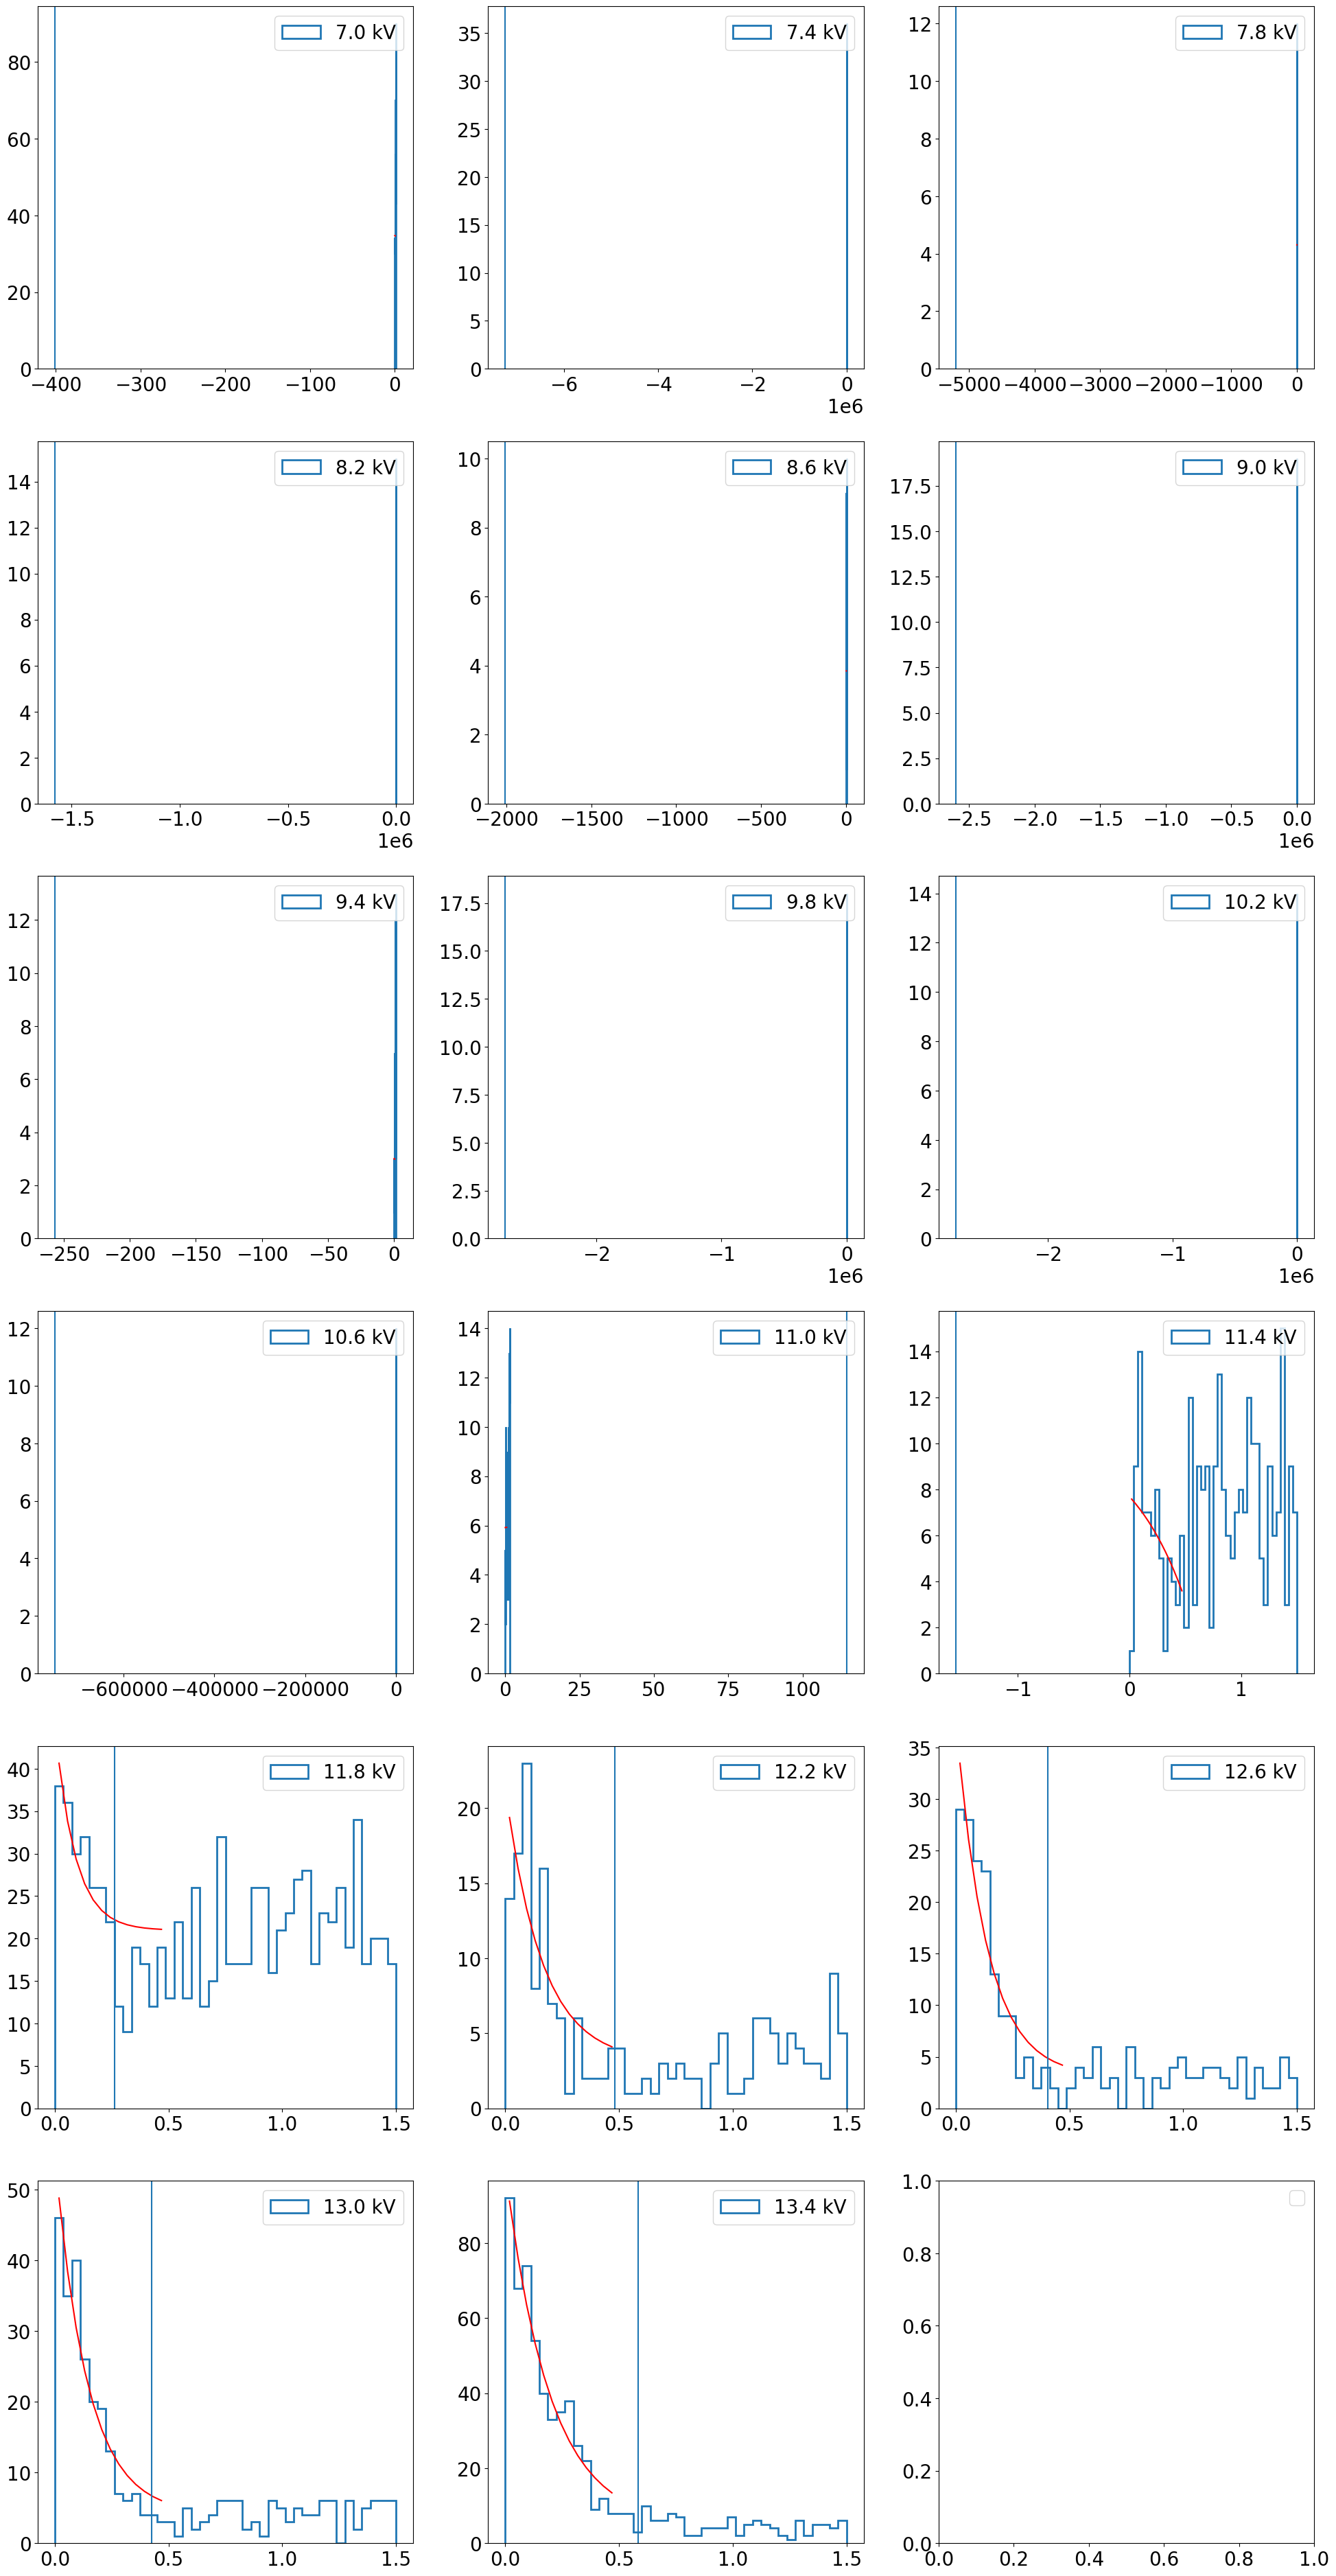

In [75]:



nrows     = len(el_volts)//3 + 1
fig_e, axes_e = plt.subplots(nrows, 3, figsize=(24, 8*nrows))
fig_c, axes_c = plt.subplots(nrows, 3, figsize=(24, 8*nrows))
fig_t, axes_t = plt.subplots(nrows, 3, figsize=(24, 8*nrows))

axes_e = axes_e.flatten()
axes_c = axes_c.flatten()
axes_t = axes_t.flatten()

ratio     = np.where(el_volts<8, el_volts/np.max(el_volts)**2, el_volts/np.max(el_volts))
enebins_c = np.linspace(0., 12.2, 501)
enebins_t = np.linspace(0., 1.5, 41)
normed = False
var    = 'energy'

eref_kev  = 5.9

erange    = [2000, 6000]
sels_e_1  = []
nsigma    = 3
eref      = 500
sigma_ref = 150/nsigma

centers   = np.array([5.9, 6.5])
int_ratio = np.array([11142, 1299])

mus, sigmas = [], []
thr_decay   = []

enebins = np.linspace(0, 10000, 1001)
### Fit

for jj, data_1_s2, label_1 in zip(range(len(labels)), datasets_s2, labels):
    #if label_1 !='7.5 kV': continue
    #enebins   = np.linspace(00, 2000, 201) if el_volts[jj]<8 else np.linspace(500, 5000, 201)

    y,x, *_ = axes_e[jj].hist(data_1_s2[var], enebins, histtype='step', 
         lw=2, label=label_1);
    x = coref.shift_to_bin_centers(x)
    escale_1 = x[y.argmax()]/eref_kev
    
    data_1_s2['energy_kev'] = data_1_s2[var]/escale_1
    new_sigma = sigma_ref * np.sqrt(escale_1)
    #print(x[y.argmax()])
    #print(escale_1)
    y,x, *_ = axes_c[jj].hist(data_1_s2[var+'_kev'], enebins_c, histtype='step', 
         lw=2, label=label_1);
    x = coref.shift_to_bin_centers(x)
    
    sels_e_1.append(coref.in_range(data_1_s2[var+'_kev'], *erange))

    efit   = [x[y.argmax()] - nsigma * new_sigma, x[y.argmax()] + nsigma * new_sigma]#escale_1 * efit0 * np.sqrt(escale_1)
    #print(efit)
    xd = x.copy()
    yd = y.copy()
    sel_f = coref.in_range(xd, *efit)
    
    mod  = GaussianModel(prefix='g1_')
    pars = mod.guess(yd[sel_f], x=xd[sel_f])
    pars['g1_amplitude'].set(min=0)
    for i in range(1, len(centers)):
        g = GaussianModel(prefix=f'g{i+1}_')
        mod += g
        params = g.make_params(center=pars['g1_center'],
                                sigma=pars['g1_sigma'],
                                amplitude=pars['g1_amplitude'])
        params[f'g{i+1}_center'].set(value=pars['g1_center'], vary=True, expr=f'g1_center*{centers[i]/centers[0]}')
        params[f'g{i+1}_sigma'].set(value=pars['g1_center'], vary=True, expr=f'g1_sigma*{np.sqrt(centers[i]/centers[0])}')
        #params[f'g{i+1}_amplitude'].set(min=0)
        params[f'g{i+1}_amplitude'].set(value=pars['g1_center'], min=0, vary=True, expr=f'g1_amplitude*{int_ratio[i]/int_ratio[0]}')

        pars.update(params)
    
    out = mod.fit(yd[sel_f], pars, x=xd[sel_f])
    
    axes_c[jj].plot(xd[sel_f], out.best_fit, '-', c='r')
    
    result =  out.result.params
    mu     = np.array([result['g1_center'].value, result['g1_center'].stderr])*escale_1/eref_kev
    sigma  = np.array([result['g1_sigma' ].value, result['g1_sigma' ].stderr])*escale_1/eref_kev
    mus.append(mu)
    sigmas.append(sigma)

    reso   = sigma[0]/mu[0] * 235
#    print(f'E resolution ({label_1}) =  {reso:.2f}% ({result["g1_center"].value} pes)')
    print(f'E resolution ({label_1}) =  {reso:.2f}%')
    #print(f'Intrinsic resolution = {get_intrinsic_resolution(eref*1000, fano, wi, mu[0], pmt_sigma)}%')

    #break

    #### Threshold limit
    
    
    y,x, *_ = axes_t[jj].hist(data_1_s2[var+'_kev'], enebins_t, histtype='step', 
         lw=2, label=label_1);
    xt = coref.shift_to_bin_centers(x)
    mod = ExponentialModel(prefix='e1_')
    
    yfit, xfit = y[xt<0.5], xt[xt<0.5]
    yfit -= y[xt>0.5].mean()
    pars = mod.guess(yfit, x=xfit)
    c   = ConstantModel(prefix=f'c1_')
    pars.add('c1_c', value=y[xt>0.8].mean(), min=0)
    mod+=c
    
    try:
        out = mod.fit(yfit, pars, x=xfit)
        axes_t[jj].plot(xfit, out.best_fit+y[xt>0.5].mean(), '-', c='r')
        
        result = out.result.params
        axes_t[jj].axvline(3*result['e1_decay'])
        
        thr_decay.append([3*result['e1_decay'].value, 3*result['e1_decay'].stderr])
        
    except:
        thr_decay.append([0, 0])
    
for ax in axes_e:
    ax.legend(loc=1)
    #ax.set_yscale('log')
    ax.set_xlabel('Energy (pes)')

for ax in axes_c:
    ax.legend(loc=1)
    ax.set_xlabel('Energy (keV)')
    #ax.set_xlim(0, 1)

for ax in axes_t:
    ax.legend(loc=1)
    #ax.set_xlim(0, 1)


ar_xray   = [2.9, 3.2]
colors    = ['b'] * len(ar_xray)
#al_xray   = [1.5]
#colors   += ['k'] * fe_lines
fe_lines  = [5.9, 6.5]
colors   += ['k'] * len(fe_lines)
cu_lines = [9.4]
colors   += ['r'] * len(cu_lines)

am_lines = [13.9, 17.7, 26.3, 59.6][:3] # From 2212.11515
colors   += ['g'] * len(am_lines)
am_lines2 = [am - 3 for am in am_lines]
colors   += ['olive'] * len(am_lines)
energy_lines = ar_xray  + fe_lines + cu_lines +  am_lines + am_lines2

for color, line in zip(colors, energy_lines):
    #axes[1].axvline(line, c=color, ls='--')
    pass
#axes[0].axvspan(*erange, alpha=0.2)
#axes[1].axvspan(*erange, alpha=0.2)
#plt.xlim(0, 100)

mus       = np.array(mus      )
sigmas    = np.array(sigmas   )
thr_decay = np.array(thr_decay)

In [76]:
#columns = ['pressure', 'run_number', 'el_voltage', 'cath_voltage', 'photons_kev', 'photons_kev_e', 'sigma_kev', 'sigma_kev_e']

data    = {'pressure'     :np.full(len(el_volts), pressure),
           'run_number'   :np.array(all_runs).flatten(),
           'el_volt'      :el_volts,
           'cath_volt'    :el_volts+delta_volt,
           'photons_kev'  :mus[:,0],
           'photons_kev_e':mus[:,1],
           'sigma_kev'    :sigmas[:,0],
           'sigma_kev_e'  :sigmas[:,1],
           'thr_kev'      :thr_decay[:,0],
           'thr_kev_e'    :thr_decay[:,1],
           'resolution'   :sigmas[:,0]/mus[:,0] *235
          }

dst = pd.DataFrame(data)
dst.to_hdf(dst_path, f'{source}_{pressure:.2f}bar_{gas}')

In [16]:
for k, v in data.items():
    print(f'{k} len of {len(v)}')

pressure len of 17
run_number len of 16
el_volt len of 17
cath_volt len of 17
photons_kev len of 16
photons_kev_e len of 16
sigma_kev len of 16
sigma_kev_e len of 16
resolution len of 16


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

axes[0].errorbar(dst.el_volt/dst.pressure/dist, dst.photons_kev/dst.pressure, label='Data', marker='o',ls='--', c='k')
axes[1].errorbar(dst.el_volt/dst.pressure/dist, dst.resolution              , label='Data', marker='o',ls='--', c='k')
axt = axes[0].twinx()
axt.errorbar(dst.el_volt/dst.pressure/dist, dst.photons_kev/dst.pressure*(wi/1000), label='Data', marker='o',ls='--', c='k')

for ax in axes:
    ax.set_xlabel('EL field (kV/cm/bar)')
    #ax.legend()
    
axes[0].set_ylabel('Det. photons / keV')
axt    .set_ylabel('Det. photons / e⁻')
axes[1].set_ylabel('Resolution (% FWHM)')

fig.tight_layout()
#intrinsic_e   = np.array([get_intrinsic_resolution(eref*1000, fano, wi, mu/3, pmt_sigma) for mu in mus[:,0]])
